# Tesla Stock Price Prediction

##Problem Description

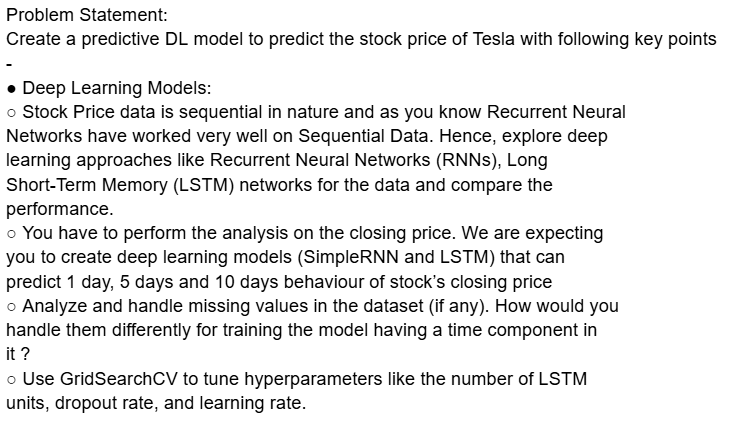

##Objectives

*   Use the model predictions to develop an algorithmic trading strategy
*   Automate buying/selling stocks based on predicted price trends
*   Allow Investors in assessing future price movements for portfolio adjustment
*   Predict stock volatility and helping with hedging, options, futures trading
*   Time based Financial Forecasting and Analysis
*   Predicting Company Valuation and Earnings







##Solution

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import sklearn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, Dense, Embedding, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_data = '/content/TSLA.csv'
df_data = pd.read_csv(file_data)

In [3]:
df_data.shape

(2416, 7)

In [4]:
df_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


Converting to Datetime

In [5]:
df_data['Date'] = pd.to_datetime(df_data['Date'])
df_data.set_index('Date', inplace=True)
df_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


Check for Duplicates

In [6]:
df_data.duplicated().sum()

np.int64(0)

Addressing Missing Values

In [7]:
df_data.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [8]:
df_data['Close'] = df_data['Close'].interpolate(method='time')

### EDA

Closing Price Over Time

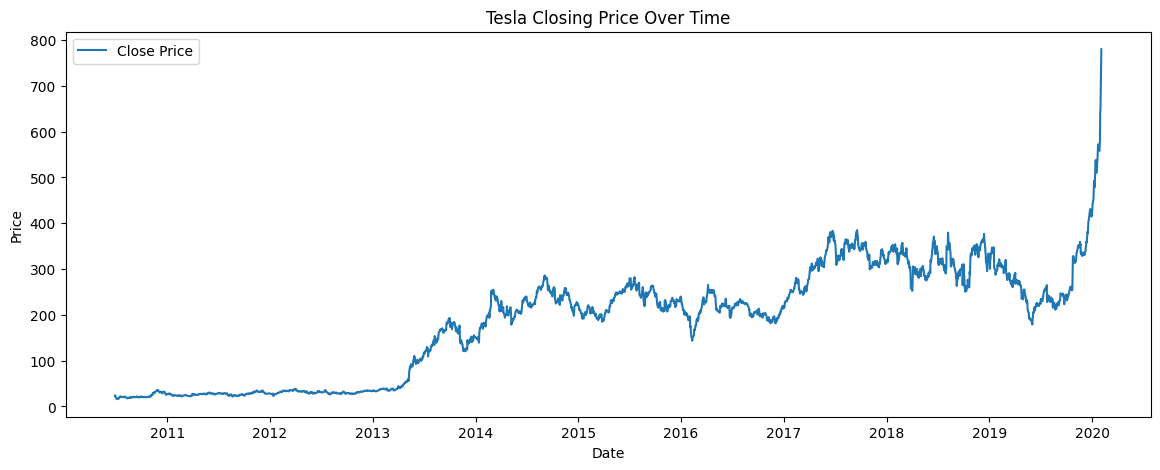

In [9]:
plt.figure(figsize=(14,5))
plt.plot(df_data.index, df_data['Close'], label='Close Price')
plt.title('Tesla Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Key Takeaways from the stock trends

*   High volatility
*   Long-term upward trend
*   Sudden dips due to market events


Daily Spread of Stock(High-Low)

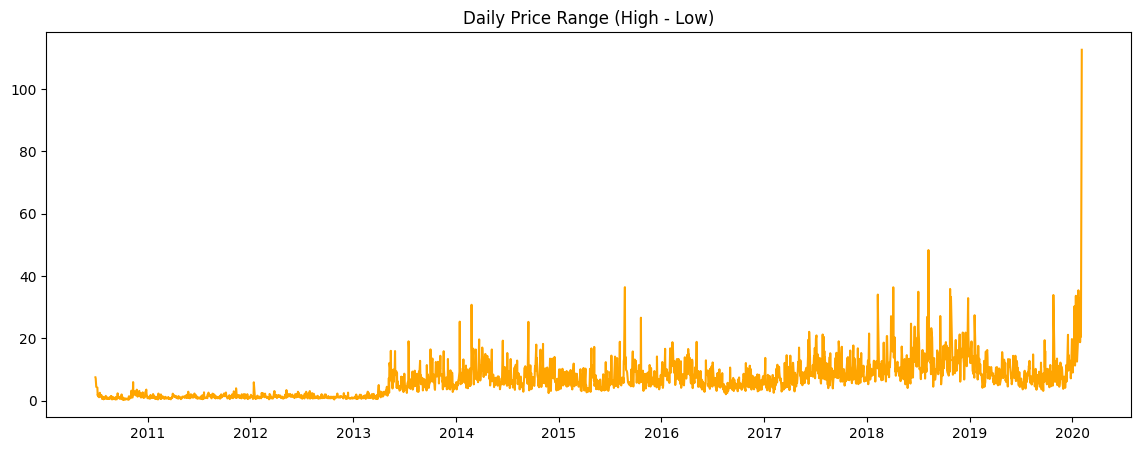

In [10]:
df_data['Daily_Range'] = df_data['High'] - df_data['Low']

plt.figure(figsize=(14,5))
plt.plot(df_data.index, df_data['Daily_Range'], color='orange')
plt.title('Daily Price Range (High - Low)')
plt.show()

Based on the Daily Spread, both volatility and risk of the stock is increasing as price increases with every passing year and increasing sharply in 2020

Rolling Volatility(20 day)

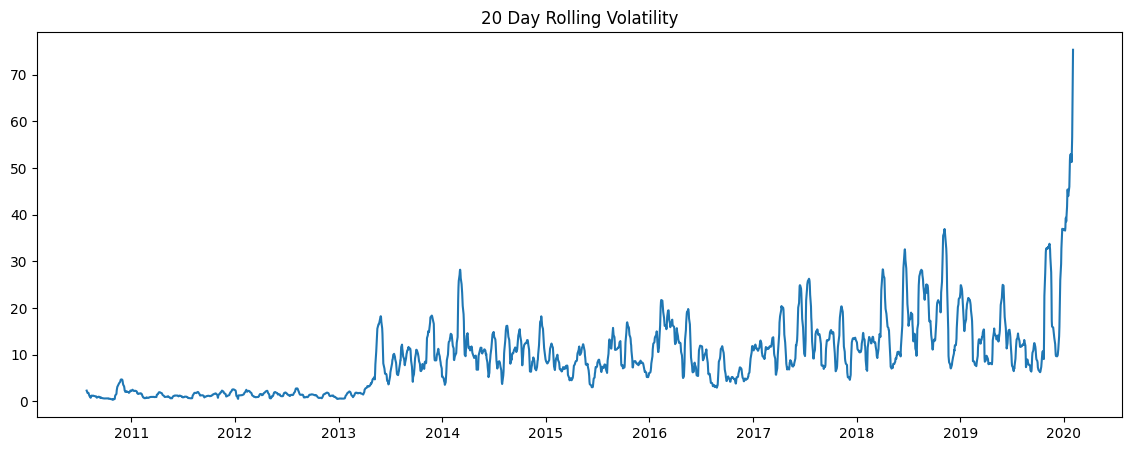

In [11]:
df_data['Rolling_STD_20'] = df_data['Close'].rolling(window=20).std()

plt.figure(figsize=(14,5))
plt.plot(df_data.index, df_data['Rolling_STD_20'])
plt.title('20 Day Rolling Volatility')
plt.show()

From this graph we can see the market uncertainty is also steadily increasing as we approach 2020

Histogram of Closing Price

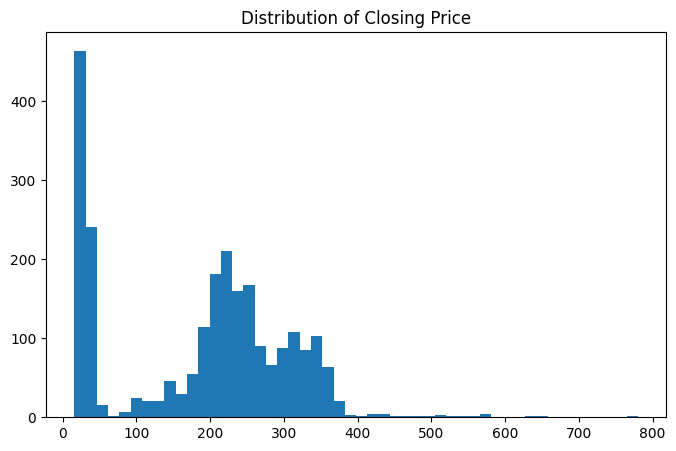

In [12]:
plt.figure(figsize=(8,5))
plt.hist(df_data['Close'], bins=50)
plt.title('Distribution of Closing Price')
plt.show()

As expected the data is skewed towards the avg stock price with some outlier values present below 100

Trading Volume Over Time

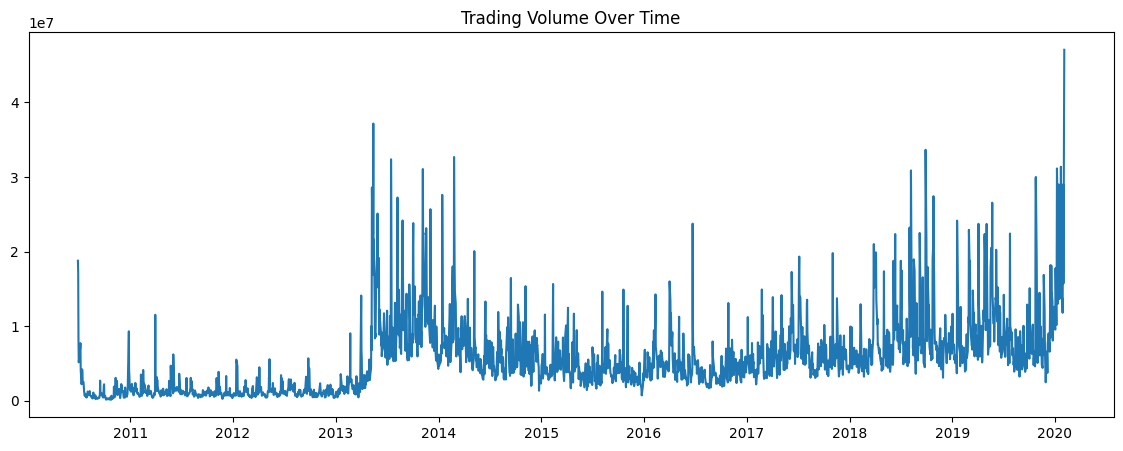

In [13]:
plt.figure(figsize=(14,5))
plt.plot(df_data.index, df_data['Volume'])
plt.title('Trading Volume Over Time')
plt.show()

This graph suggests that market participation in trading of the stock rose significantly after 2013 and in 2020

Close Price vs Volume

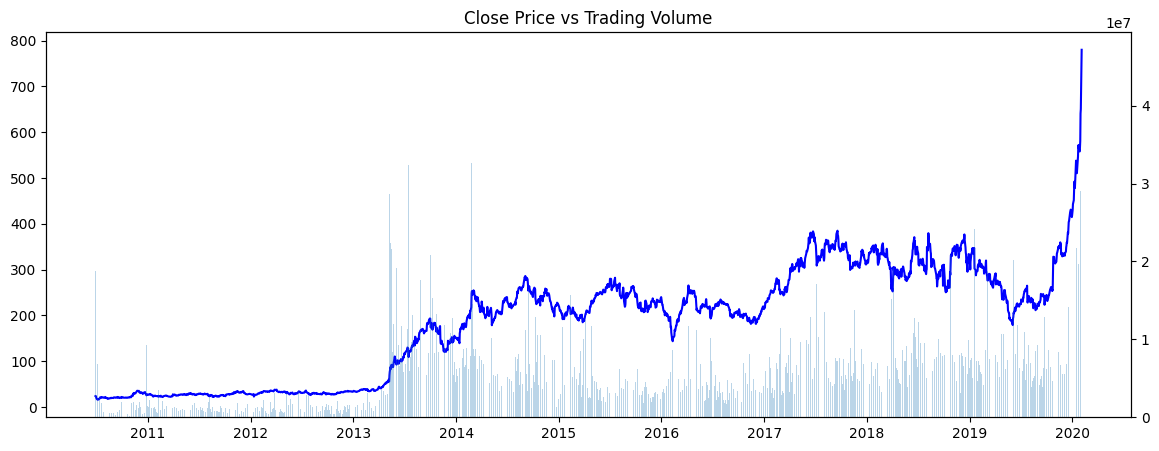

In [14]:
fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(df_data.index, df_data['Close'], color='blue')
ax2 = ax1.twinx()
ax2.bar(df_data.index, df_data['Volume'], alpha=0.3)

ax1.set_title('Close Price vs Trading Volume')
plt.show()


This graph confirms that the pricing of the stock exhibited significant growth whenever volume of trading increased and the closing price showed plateauing whenever volume of trading dropped below normal

Correlation Heatmap (Price to Volume)

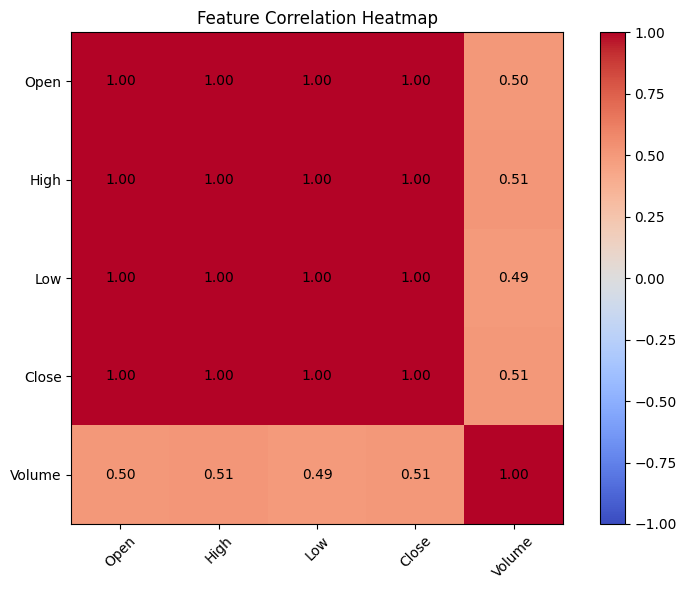

In [15]:
corr = df_data[['Open','High','Low','Close','Volume']].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()

plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)

# Add correlation values
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                 ha="center", va="center", color="black")

plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

This chart confirms the following:

Higher volume often accompanying price movement
Since volume does not directly determine price, therefore suggests moderate positive correlation, hence not near 1

Defining Features & Target

In [16]:
FEATURE_COLUMNS = [
    "Close",
    "Volume",
    "MA20",
    "MA50",
    "Rolling_STD_20"
]

In [17]:
df_feat = df_data.copy()

df_feat["MA20"] = df_feat["Close"].rolling(window=20).mean()
df_feat["MA50"] = df_feat["Close"].rolling(window=50).mean()
df_feat["Rolling_STD_20"] = df_feat["Close"].rolling(window=20).std()

df_feat.dropna(inplace=True)

In [18]:
X = df_feat[FEATURE_COLUMNS]
y = df_feat[["Close"]]

Pipeline and Scaling

In [19]:
price_pipeline = Pipeline(
    steps=[
        ('scaler', MinMaxScaler(feature_range=(0, 1)))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('price', price_pipeline, ['Close'])
    ],
    remainder='drop'
)

Train Test (Time based)

In [20]:
train_size = int(len(X) * 0.8)
X_train_raw = X.iloc[:train_size]

X_train_scaled = preprocessor.fit_transform(X_train_raw)

Save Pipe

In [21]:
joblib.dump(preprocessor, "preprocessing_pipeline.joblib")

['preprocessing_pipeline.joblib']

Generate Time Series Sequences

In [22]:
def create_sequences(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+horizon])
    return np.array(X), np.array(y)

Model Building


In [23]:
def build_model(model_type, input_shape, horizon):
    model = Sequential()

    if model_type == "rnn":
        model.add(SimpleRNN(50, input_shape=input_shape))
    elif model_type == "lstm":
        model.add(LSTM(50, input_shape=input_shape))
    else:
        raise ValueError("Unknown model type")

    model.add(Dropout(0.2))
    model.add(Dense(horizon))

    model.compile(
        optimizer="adam",
        loss="mse"
    )

    return model

Model Training for 1d, 5d, 10d Predictions

In [24]:
WINDOW_SIZE = 80
HORIZONS = [1, 5, 10]
MODEL_TYPES = ["rnn", "lstm"]

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

for model_type in MODEL_TYPES:
    for horizon in HORIZONS:
        print(f"\nTraining {model_type.upper()} model for {horizon}-day prediction")

        X_seq, y_seq = create_sequences(
            X_train_scaled,
            WINDOW_SIZE,
            horizon
        )

        model = build_model(
            model_type=model_type,
            input_shape=(X_seq.shape[1], X_seq.shape[2]),
            horizon=horizon
        )

        model.fit(
            X_seq,
            y_seq,
            epochs=60,
            batch_size=32,
            validation_split=0.1,
            callbacks=callbacks,
            verbose=1
        )

        model_path = f"{model_type}_model_{horizon}d.keras"
        model.save(model_path)

        print(f"Saved → {model_path}")



Training RNN model for 1-day prediction
Epoch 1/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2788 - val_loss: 0.0094
Epoch 2/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0109 - val_loss: 0.0151
Epoch 3/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 4/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0060 - val_loss: 0.0074
Epoch 5/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 6/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 7/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0033 - val_loss: 0.0061
Epoch 8/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034 - val_loss: 0.0054
Epoch 9/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 10/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 11/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 12/60
51/51 ━━━━

Model Evaluation

In [27]:
train_size = int(len(X) * 0.8)
X_train_raw = X.iloc[:train_size]
X_test_raw  = X.iloc[train_size:]
X_test_scaled = preprocessor.transform(X_test_raw)

X_test_seq_dict = {}
y_test_seq_dict = {}

for horizon in HORIZONS:
    X_seq, y_seq = create_sequences(
        X_test_scaled,
        WINDOW_SIZE,
        horizon
    )
    X_test_seq_dict[horizon] = X_seq
    y_test_seq_dict[horizon] = y_seq

results = []

scaler = preprocessor.named_transformers_['price'].named_steps['scaler']

for model_type in MODEL_TYPES:
    for horizon in HORIZONS:

        model = load_model(f"{model_type}_model_{horizon}d.keras")

        X_test_seq = X_test_seq_dict[horizon]
        y_test_seq = y_test_seq_dict[horizon]

        y_pred_scaled = model.predict(X_test_seq, verbose=0)

        y_pred = scaler.inverse_transform(y_pred_scaled)
        y_true = scaler.inverse_transform(
            y_test_seq.reshape(-1, horizon)
        )

        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)

        results.append({
            "Model": model_type.upper(),
            "Horizon": horizon,
            "MSE": mse,
            "RMSE": rmse
        })

In [28]:
results_df = pd.DataFrame(results)
results_df

,Model,Horizon,MSE,RMSE
0,RNN,1,276.323599,16.622984
1,RNN,5,432.874614,20.805639
2,RNN,10,860.818934,29.339716
3,LSTM,1,457.597444,21.391527
4,LSTM,5,1258.340612,35.473097
5,LSTM,10,981.422181,31.327658


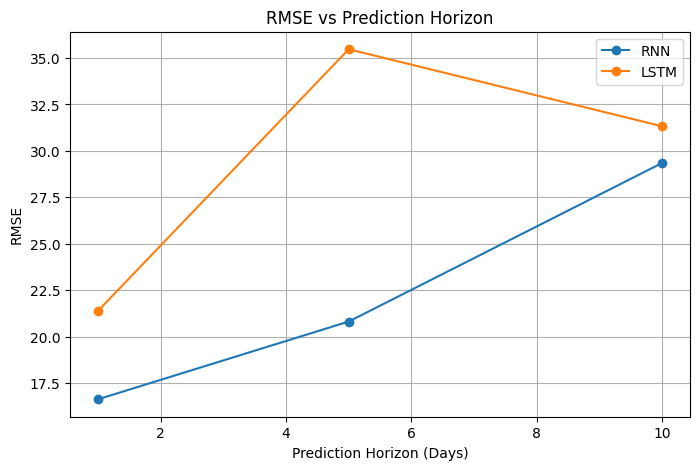

In [29]:
plt.figure(figsize=(8,5))

for model in ["RNN", "LSTM"]:
    subset = results_df[results_df["Model"] == model]
    plt.plot(
        subset["Horizon"],
        subset["RMSE"],
        marker="o",
        label=model
    )

plt.xlabel("Prediction Horizon (Days)")
plt.ylabel("RMSE")
plt.title("RMSE vs Prediction Horizon")
plt.legend()
plt.grid(True)
plt.show()

From both the metrics and the plot the SimpleRNN model appears to perform better for the dataset

In [30]:
def plot_actual_vs_pred(model_type, horizon, n_points=200):

    model = load_model(f"{model_type}_model_{horizon}d.keras")

    X_test_seq = X_test_seq_dict[horizon]
    y_test_seq = y_test_seq_dict[horizon]

    y_pred_scaled = model.predict(X_test_seq, verbose=0)

    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(
        y_test_seq.reshape(-1, horizon)
    )

    plt.figure(figsize=(12,5))
    plt.plot(y_true[:n_points], label="Actual")
    plt.plot(y_pred[:n_points], label=f"{model_type.upper()} Prediction")
    plt.title(f"{model_type.upper()} – {horizon}-Day Forecast")
    plt.legend()
    plt.show()

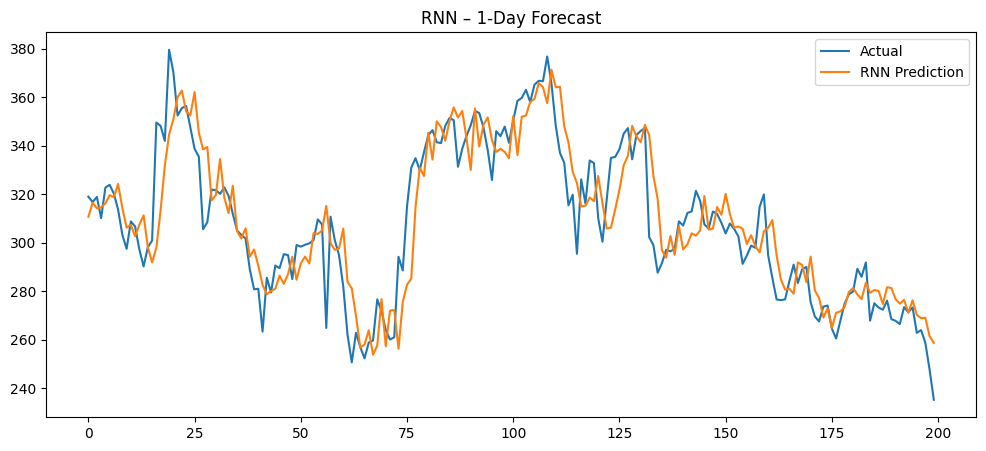

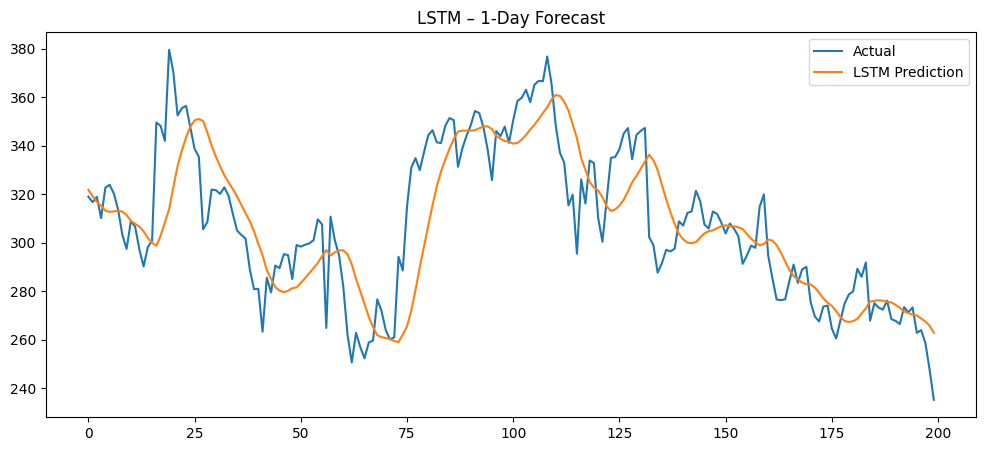

In [31]:
plot_actual_vs_pred("rnn", 1)
plot_actual_vs_pred("lstm", 1)

In the actual vs predicted plots also Simple RNN shows more tightly bound predictions whereas LSTM is lagging to meet the rapid spikes and providing a smoother curve resulting in more error when spikes are high